In [1]:
import os
import numpy as np
import pandas as pd
import re, string

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchkeras
from torchkeras import Model
from torch.autograd import Variable

In [2]:
MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20

train_data_path = './data/imdb/train.tsv'
test_data_path = './data/imdb/test.tsv'

train_token_path = './data/imdb/train_token.tsv'
test_token_path = './data/imdb/test_token.tsv'

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class imdbDataset(Dataset): # Load text token file
    def __init__(self, tokenfile_path):
        self.tokenfile_path = tokenfile_path
        with open (self.tokenfile_path, 'r', encoding='UTF-8') as f:
            self.samples_list = []
            for count, line in enumerate(f, 1):
                self.samples_list.append(line)
            self.length = count
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        sample = self.samples_list[index]
        label, tokens = sample.split("\t")
        label = torch.tensor([float(label)], dtype = torch.float).to(device)
        feature = torch.tensor([int(x) for x in tokens.split(" ")], dtype = torch.long).to(device)
        return (feature, label)

In [4]:
ds_train = imdbDataset(train_token_path)
ds_test = imdbDataset(test_token_path)
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Hyper params
EMBEDDING_DIM = 3

class MultiCNN(Model):
    def __init__(self, ):
        super(MultiCNN, self).__init__()
        
        self.window_sizes = [2, 3, 4, 5]
        self.feature_size = 32
        
        self.embedding = nn.Embedding(num_embeddings=MAX_WORDS, embedding_dim=EMBEDDING_DIM, padding_idx=1)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=EMBEDDING_DIM, out_channels=self.feature_size, kernel_size=w),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=MAX_LEN-w+1)
            )
            for w in self.window_sizes
        ])
        self.fc = nn.Linear(self.feature_size*len(self.window_sizes), 1)
        
    def forward(self, x):
        x = self.embedding(x) # (batch_size, 200, 3)
        x = x.transpose(1, 2)
        
        conv_out = [conv(x) for conv in self.convs] # (batch_size, feature_size, 1) * kernel_num=4
        conv_out = torch.cat(conv_out, dim=1) # (batch_size, feature_size*4, 1)
        
        x_in = conv_out.view(-1, conv_out.size(1)) # (batch_size, feature_size*4) 
        y = nn.Sigmoid()(self.fc(x_in))
        
        return y

model = MultiCNN()
print(model)
model.summary(input_shape = (200, ), input_dtype = torch.LongTensor)

MultiCNN(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 32, kernel_size=(2,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=199, stride=199, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=198, stride=198, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(3, 32, kernel_size=(4,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=197, stride=197, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(3, 32, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=196, stride=196, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)   

In [6]:
def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred > 0.5, 
                         torch.ones_like(y_pred, dtype=torch.float32), 
                         torch.zeros_like(y_pred, dtype=torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func=nn.BCELoss(), 
              optimizer=torch.optim.Adagrad(model.parameters(), lr = 0.02), 
              metrics_dict={"accuracy":accuracy})

In [7]:
epochs = 20
dfhistory = model.fit(epochs, dl_train, dl_val=dl_test, log_step_freq=200) 

Start Training ...

================================================================================2021-03-08 14:36:05
{'step': 200, 'loss': 0.715, 'accuracy': 0.512}
{'step': 400, 'loss': 0.703, 'accuracy': 0.52}
{'step': 600, 'loss': 0.696, 'accuracy': 0.53}
{'step': 800, 'loss': 0.691, 'accuracy': 0.543}
{'step': 1000, 'loss': 0.686, 'accuracy': 0.555}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.686 |  0.555   |  0.662   |    0.616     |
+-------+-------+----------+----------+--------------+

================================================================================2021-03-08 14:36:19
{'step': 200, 'loss': 0.65, 'accuracy': 0.627}
{'step': 400, 'loss': 0.646, 'accuracy': 0.632}
{'step': 600, 'loss': 0.643, 'accuracy': 0.638}
{'step': 800, 'loss': 0.638, 'accuracy': 0.645}
{'step': 1000, 'loss': 0.633, 'accuracy': 0.649}

 +-------+-------+----

{'step': 400, 'loss': 0.394, 'accuracy': 0.819}
{'step': 600, 'loss': 0.39, 'accuracy': 0.822}
{'step': 800, 'loss': 0.389, 'accuracy': 0.823}
{'step': 1000, 'loss': 0.387, 'accuracy': 0.826}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   14  | 0.387 |  0.826   |  0.432   |    0.801     |
+-------+-------+----------+----------+--------------+

================================================================================2021-03-08 14:39:34
{'step': 200, 'loss': 0.387, 'accuracy': 0.827}
{'step': 400, 'loss': 0.389, 'accuracy': 0.824}
{'step': 600, 'loss': 0.386, 'accuracy': 0.826}
{'step': 800, 'loss': 0.383, 'accuracy': 0.827}
{'step': 1000, 'loss': 0.38, 'accuracy': 0.83}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   15  | 0.38 |   0.83   |

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


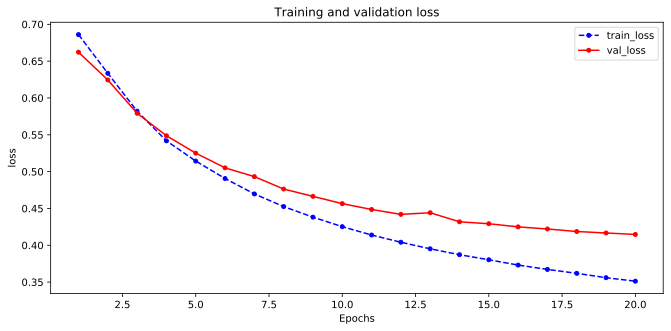

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.figure(figsize=(11, 5))
    plt.plot(epochs, train_metrics, 'bo--', markersize=4)
    plt.plot(epochs, val_metrics, 'ro-', markersize=4)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")

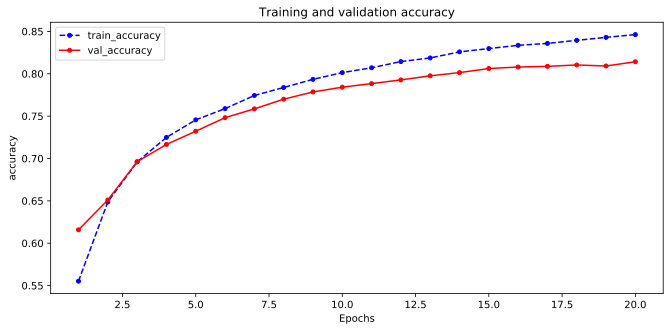

In [9]:
plot_metric(dfhistory, "accuracy")

In [10]:
print(dfhistory.loc[:, "accuracy"].max())
print(dfhistory.loc[:, "val_accuracy"].max())

0.8462499999403954
0.8141999995708465
